# Installing required libraries 

In [12]:
!pip install -r requirements.txt                                                                   


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Importing dependencies

In [53]:
import tensorflow as tf
import matplotlib.pyplot as plt
import albumentations as alb
import random as rand
import os 
import cv2 
import numpy as np
import joblib
import shutil
import uuid
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D ,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental import preprocessing

# GPU support for tensorflow

In [2]:
gpus = tf.config.list_physical_devices("GPU")

if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
        print(f"{len(gpus)} GPU(s) available")
        print(gpu)
else:
    print("No GPU available")

1 GPU(s) available
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# Predefined functions

In [3]:
def load_data(path):
    images = []
    img_types = ("jpg", "jpeg", "PNG", "bmp", "png")
    for filename in os.listdir(path):
        if filename.endswith(img_types):
            img = cv2.imread(os.path.join(path, filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = crop_image((16,9),img)
            images.append(img)
    return images

def load_partition(path):
    partition = tf.keras.utils.image_dataset_from_directory(path,image_size=(227,128),batch_size=64)
    partition = partition.map(lambda x,y:(x/255,y))
    partition = partition.prefetch(tf.data.experimental.AUTOTUNE)
    return partition

def crop_image(ratio,img):
    y,x = ratio
    
    old_y,old_x,_ = img.shape 
    
    new_x = old_x
    new_y = int(new_x * y/x)
    
    if new_y > old_y:
        new_y = old_y
        new_x = int(new_y * x/y)
    
    centre_x = int(old_x/2)
    centre_y = int(old_y/2)
    start_x = centre_x - int(new_x/2)
    end_x = centre_x + int(new_x/2)
    
    start_y = centre_y - int(new_y/2)
    end_y = centre_y + int(new_y/2)
     
    
    cropped_img = img[start_y:end_y,start_x:end_x]
    
    return cropped_img
     

def show_images(images,labels=None):
    fig,ax = plt.subplots(ncols=5,figsize=(10,10))
    for i,img in enumerate(images):
        if i >= len(ax):
            break
        ax[i].imshow(img)
        ax[i].axis("OFF")
    plt.tight_layout()
    plt.title(labels)
    plt.show()
    
def augmet_imgs(imgs):
    aug_imgs = []
    augmentation = alb.Compose([
                            alb.RandomBrightnessContrast(p=0.5),
                            alb.RGBShift(p=0.2),
                            alb.HorizontalFlip(p=0.5),         
                            alb.Rotate(limit=30,p=0.5)
                            ])
    
    for img in imgs:
        for i in range(20):
            aug_img = augmentation(image=img)
            aug_imgs.append(aug_img["image"])
    return aug_imgs

def optimize_imgs(imgs):
    opt_imgs = []
    for img in imgs:
        k = 128 
        y,x,_ = img.shape
        if y < x:
            c = y/k
            y = int(y/c)
            x = int(x/c)

        else:
            c = x/k
            y = int(y/c)
            x = int(x/c)

            
        img = cv2.resize(img,(x,y))
        opt_imgs.append(img)
    
    return opt_imgs
        
def dump_imgs(imgs,path):
    for img in imgs:
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        cv2.imwrite(path+"/"+str(uuid.uuid4())+".jpg",img)
    
def process(path,augment=True):
    for category in os.listdir(path):
        
        dir = os.path.join(path,category)
        destination = os.path.join("./Processed",dir)
        
        train = load_data(dir)
        train = optimize_imgs(train)
        
        if augment:
            train = augmet_imgs(train)
        
        show_images(train,f"shape:{train[0].shape}") 
        
        if os.path.exists(destination):
            shutil.rmtree(destination)

        os.makedirs(destination)
        dump_imgs(train,destination)
        
        print(f"successfully_dumped{destination}")

# Processing and dumping partitions in processed directory

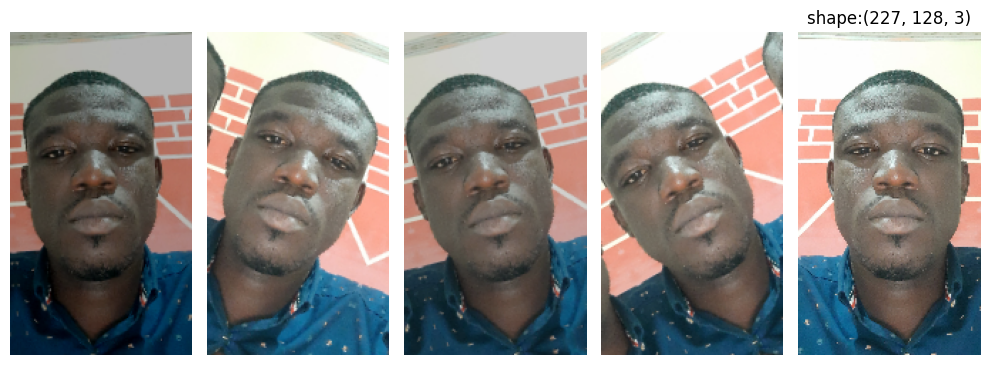

successfully_dumped./Processed\./train\men


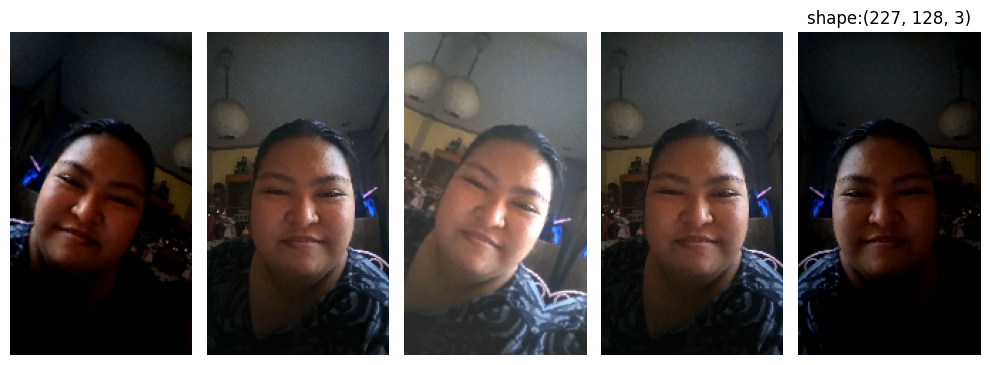

successfully_dumped./Processed\./train\women


In [ ]:
process("./train")

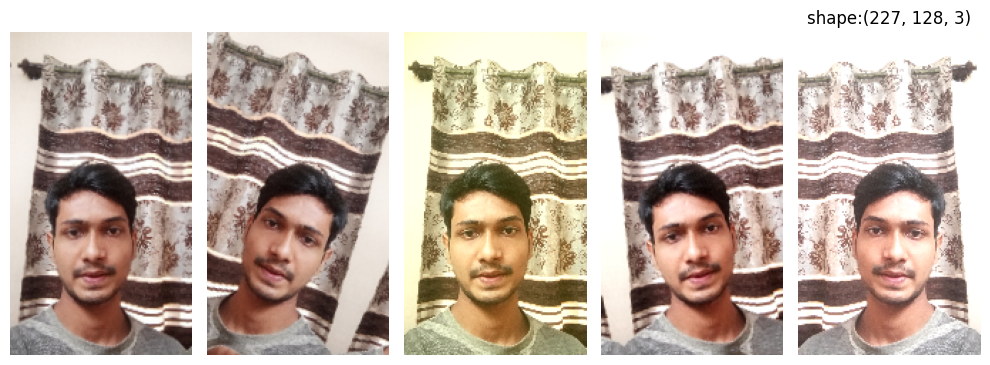

successfully_dumped./Processed\./valid\men


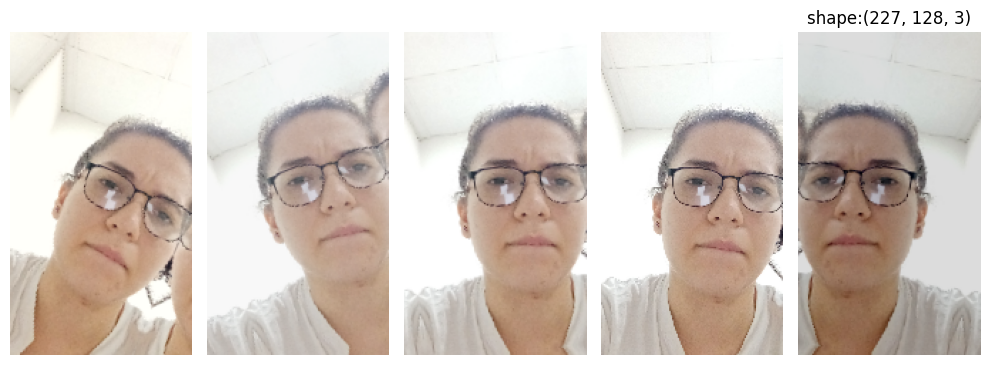

successfully_dumped./Processed\./valid\women


In [17]:
process("./valid")

# loading partitions form Processed directory 

In [ ]:
Train = load_partition("./Processed/train")
Valid = load_partition("./Processed/valid")

Found 4420 files belonging to 2 classes.
Found 1580 files belonging to 2 classes.


# Custom CNN layout

In [36]:
model = Sequential([
    
Conv2D(16,(3,3),activation="relu",input_shape=(227,128,3),kernel_regularizer=tf.keras.regularizers.l2(0.1)),
BatchNormalization(),
MaxPooling2D((2,2)),
Dropout(0.25),

Conv2D(32,(3,3),activation="relu",kernel_regularizer=tf.keras.regularizers.l2(0.1)),
BatchNormalization(),
MaxPooling2D((2,2)),
Dropout(0.25),

Conv2D(64,(3,3),activation="relu",kernel_regularizer=tf.keras.regularizers.l2(0.1)),
MaxPooling2D((2,2)),
BatchNormalization(),
Dropout(0.25),

Flatten(),
Dense(128,activation="relu"),
Dropout(0.5),
Dense(1,activation="sigmoid"),
])

In [ ]:
model.summery()

# loss metrix and optimizer

In [ ]:
model.compile(loss=tf.losses.BinaryCrossentropy(),
              optimizer="adam",
              metrics=["binary_accuracy"]
)

NameError: name 'model' is not defined

# Callbacks

In [ ]:
model_name = "model.plk"

In [25]:

early_stopping = tf.keras.callbacks.EarlyStopping(patience=20,
                                                restore_best_weights=True,
                                                min_delta=0.0001,
                                                )

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                                                    filepath=model_name,
                                                    save_weights_only=False,
                                                    monitor="val_loss",
                                                    mode="auto",
                                                    save_best_only=True,
                                                    )

# Training and saving the model

In [ ]:
#benchmark V_loss = 0.000277
if (os.path.exists(model_name)):
    shutil.rmtree(model_name)

NameError: name 'os' is not defined

In [7]:
model_name = "temp.plk"

his = model.fit(Train,
                validation_data = Valid,
                callbacks = [early_stopping,model_checkpoint],
                epochs = 500
                )

model.save(model_name)                  

NameError: name 'model' is not defined

# train and validation Accuracy and loss Graph

In [39]:
minima = min(his.history["val_loss"])
print(minima)

fig,axes = plt.subplots(ncols = 2,figsize=(12,5))
axes[0].plot(his.history["binary_accuracy"],color="blue",label="accuracy")
axes[0].set_title("Accuracy")
axes[0].plot(his.history["val_binary_accuracy"],color="green",label="val_accuracy")
axes[0].legend(loc="upper left")
axes[1].plot(his.history["loss"],color="blue",label="loss")
axes[1].set_title("Loss")
axes[1].plot(his.history["val_loss"],color="green",label="val_loss")
axes[1].legend(loc="upper left")
plt.plot()

NameError: name 'his' is not defined

# Evalutation of model on test partition

In [18]:
model = tf.keras.models.load_model(model_name)        

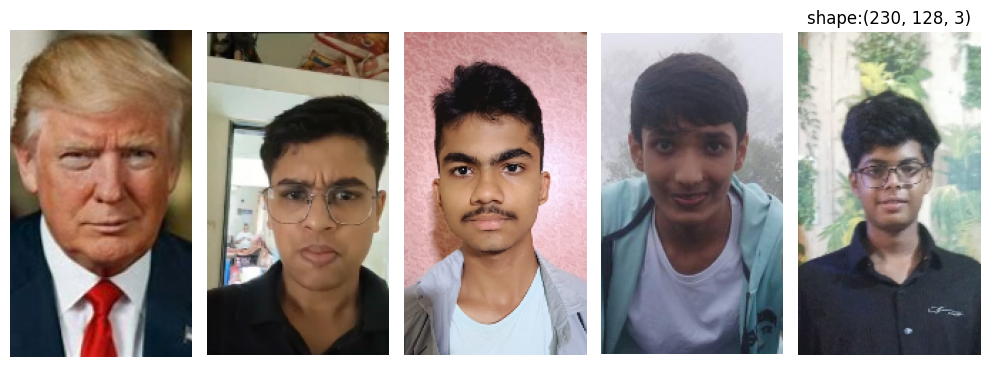

successfully_dumped./Processed\./test\men


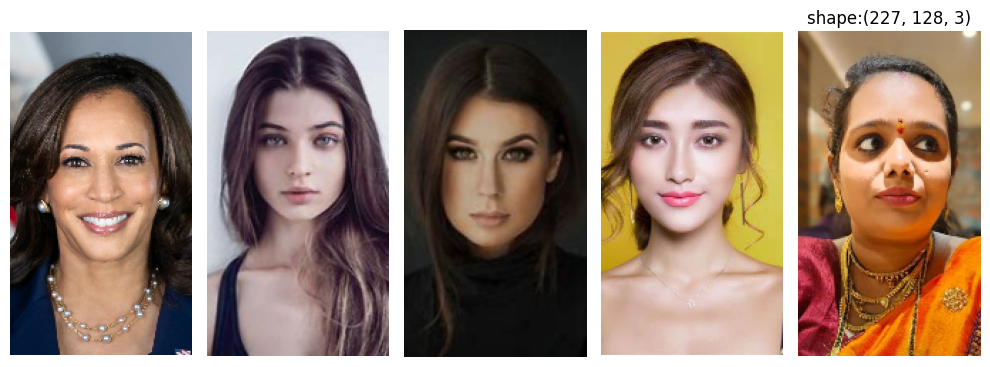

successfully_dumped./Processed\./test\women


In [44]:
process("./test",augment=False)

In [45]:
test = load_partition("./Processed/test")

Found 10 files belonging to 2 classes.


In [62]:
imgs,labels = test.as_numpy_iterator().next()

print(type(imgs))

<class 'numpy.ndarray'>


In [47]:
pred = model.predict(imgs)
print(pred)

1/1 [==============================] - 0s 22ms/step
[[0.9999714 ]
 [0.01301276]
 [0.9995926 ]
 [0.01987495]
 [0.99853325]
 [0.00911352]
 [0.01621385]
 [0.99979943]
 [0.06082132]
 [0.70125186]]


In [48]:
result = np.round(pred)
print(result)

[[1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]]


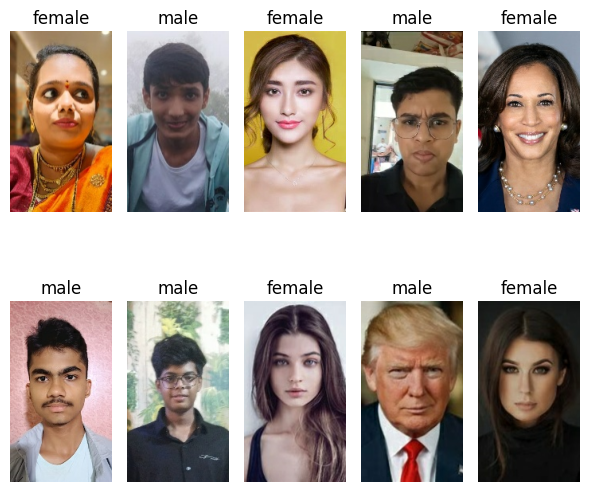

In [49]:
batch = imgs

fig,ax = plt.subplots(ncols=5,nrows=2,figsize=(6,6))

for i,img in enumerate(imgs):
    x = i%5
    y = i//5
    
    ax[y,x].imshow(img)
    ax[y,x].axis("OFF")
    
    if result[i] >= 0.5:
        ax[y,x].set_title("female")
    else:
        ax[y,x].set_title("male")
            
plt.axis("OFF")
plt.tight_layout()
plt.show()

# Loss and Accuracy of the model on test partition

In [41]:
test_loss, test_accuracy = model.evaluate(test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

1/1 [==============================] - 0s 100ms/step - loss: 0.4294 - binary_accuracy: 1.0000
Test Loss: 0.4293580949306488
Test Accuracy: 1.0


# Testing model on single sample

In [67]:
Img =  imgs[rand.randint(0,len(imgs)-1)]
Img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
Img = np.expand_dims(Img,axis=0)
pred = model.predict(Img)
pred = pred[0][0]
print(pred)

1/1 [==============================] - 0s 19ms/step
0.9947189


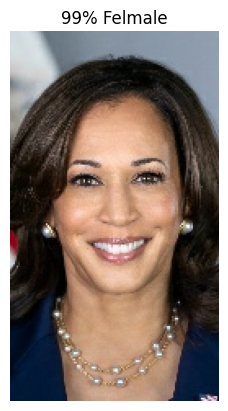

In [ ]:
plt.imshow(Img)
plt.axis("OFF")

F_probablity = round(pred*100)
M_probablity = round(100-F_probablity)

if pred > 0.5:
    plt.title(f"{F_probablity}% Felmale")    
else:
    plt.title(f"{M_probablity}% Male")